In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
from jax.scipy.special import expit as sigmoid
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata

from jaxbo.mcmc_models import GPclassifier
from jaxbo.utils import normalize, compute_w_gmm
from jaxbo.input_priors import uniform_prior

onp.random.seed(1234)

## Generate some data

In [2]:
def test_fun(X):
    return ( 0.5 + np.sin(2.5*X[:,0]*np.pi)/3 - X[:,1]) > 0

In [3]:
N = 80
D = 2
lb = 0.0*np.ones(D)
ub = 1.0*np.ones(D)
bounds = {'lb': lb, 'ub': ub}
p_x = uniform_prior(lb, ub)

# Training data
X = lb + (ub - lb)*lhs(2,N) # generate data with a Latin hypercube desing
y = 1.0*test_fun(X)

# Test data
nn = 50
xx = np.linspace(lb[0], ub[0], nn)
yy = np.linspace(lb[1], ub[1], nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)
y_star = test_fun(X_star)

## Model setup

In [4]:
options = {'kernel': 'RBF',
           'criterion': None, 
           'input_prior': p_x,
           'kappa': None,
           'nIter': None}
mcmc_settings = {'num_warmup': 500,
                 'num_samples': 50,
                 'num_chains': 1,
                 'target_accept_prob': 0.9}
gp_model = GPclassifier(options)

## Training

In [5]:
rng_key = random.PRNGKey(123)
data = {'X': X, 'y': y}
print('Train GP...')
key_train, key_test = random.split(rng_key)
samples = gp_model.train(data,
                         key_train,
                         mcmc_settings,
                         verbose = True)

Train GP...


sample: 100%|██████████| 550/550 [00:13<00:00, 39.69it/s, 31 steps of size 1.64e-01. acc. prob=0.94] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
            beta      0.10      0.97      0.10     -1.66      1.57     78.25      0.98
          eta[0]     -0.39      0.50     -0.25     -1.33      0.34     65.59      1.01
          eta[1]     -1.32      0.67     -1.13     -2.49     -0.41     30.43      1.02
          eta[2]      1.43      0.85      1.31      0.10      2.58    147.94      0.99
          eta[3]      0.28      0.28      0.27     -0.23      0.64     49.37      1.02
          eta[4]      0.12      0.49      0.08     -0.66      0.89     23.43      1.02
          eta[5]     -1.34      0.62     -1.22     -2.26     -0.53     53.24      0.98
          eta[6]      1.47      0.73      1.48      0.20      2.50     59.32      0.98
          eta[7]     -1.00      0.82     -1.00     -2.24      0.43     51.15      1.00
          eta[8]     -0.03      0.89     -0.23     -1.13      1.59     28.06      0.98
          eta[9]      1.25      0.74      

In [6]:
# Compute predictions
rng_keys = random.split(key_test, 
                        mcmc_settings['num_samples'] * mcmc_settings['num_chains'])
kwargs = {'samples': samples,
          'batch': data,
          'bounds': bounds,
          'rng_key': key_test,
          'rng_keys': rng_keys}
mean, std = gp_model.predict(X_star, **kwargs)
acq = np.abs(mean)/(std + 1e-8)
new_X = X_star[np.argmin(acq), :]

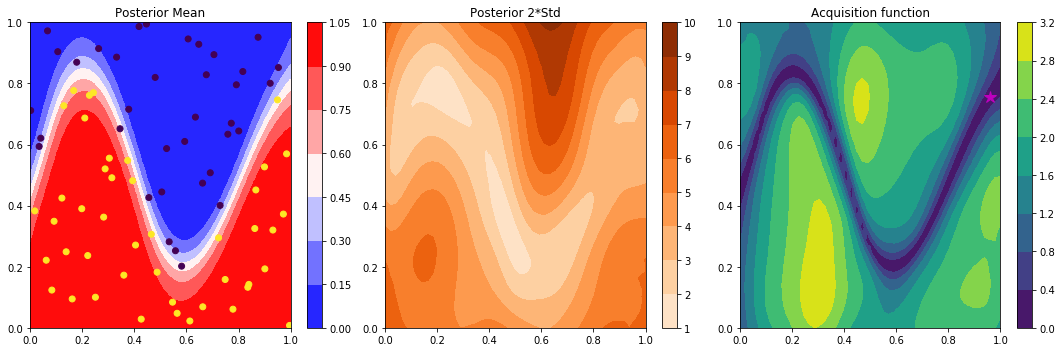

In [12]:
Mplot = mean.reshape(nn,nn)
Splot = std.reshape(nn,nn)
Aplot = acq.reshape(nn,nn)

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.contourf(XX, YY, sigmoid(Mplot), cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
plt.colorbar()
plt.scatter(X[:,0], X[:,1], c = y)
plt.title('Posterior Mean')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.contourf(XX, YY, 2.0*Splot, cmap=plt.get_cmap('Oranges'), vmin=0)
plt.colorbar()
# plt.scatter(X[:,0], X[:,1], c = y)
plt.title('Posterior 2*Std')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.contourf(XX, YY, Aplot)
plt.plot(new_X[0], new_X[1], 'm*', ms = 12)
plt.colorbar()
# plt.scatter(X[:,0], X[:,1], c = y)
plt.title('Acquisition function')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()

In [8]:
# # Fit GMM
# kwargs = {'samples': samples,
#           'batch': data,
#           'bounds': bounds,
#           'rng_key': key_test,
#           'rng_keys': rng_keys}
# gmm_vars = gp_model.fit_gmm(**kwargs, N_samples = 10000)

In [9]:
# kwargs = {'samples': samples,
#           'batch': data,
#           'bounds': bounds,
#           'rng_key': key_test,
#           'gmm_vars': gmm_vars}
# w_pred = compute_w_gmm(X_star, **kwargs)

In [10]:
# plt.figure(figsize = (12,4))
# plt.subplot(1, 2, 1)
# plt.contourf(XX, YY, Wplot)
# plt.colorbar()
# plt.title('$w_{GMM}$')
# plt.xlim([lb[0], ub[0]])
# plt.ylim([lb[1], ub[1]])
# plt.tight_layout()

# plt.subplot(1, 2, 2)
# plt.contourf(XX, YY, AAplot)
# plt.colorbar()
# plt.title('Acquisition function')
# plt.xlim([lb[0], ub[0]])
# plt.ylim([lb[1], ub[1]])
# plt.tight_layout()